## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [76]:
#from google.colab import drive
#drive.mount('/content/drive')

In [77]:
# Make sure to change path if you put the zip elsewhere
#!unzip drive/MyDrive/chest_xray.zip

## Create dataset from directory

In [78]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


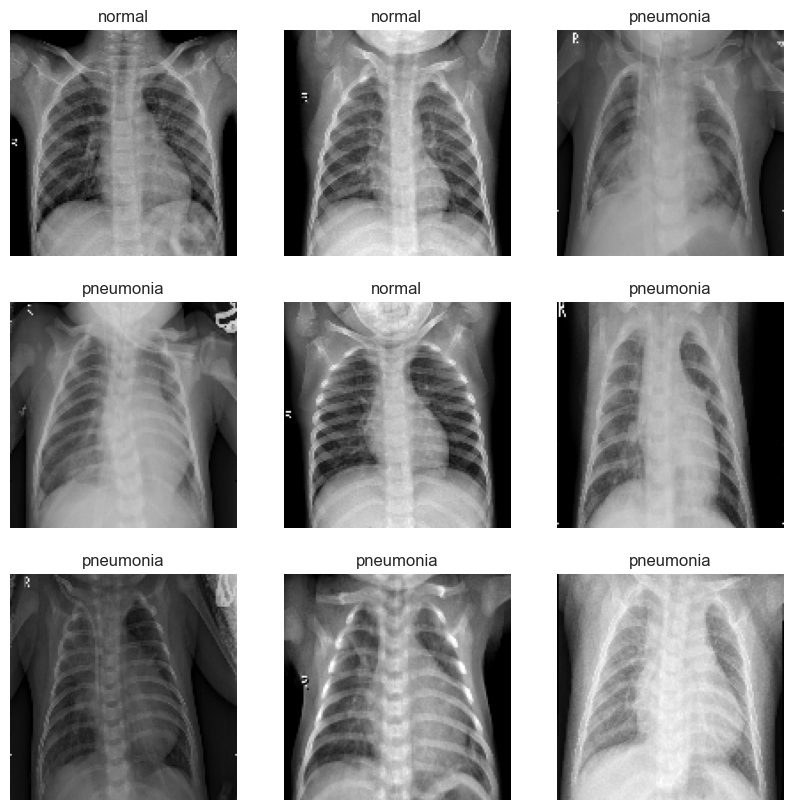

In [79]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [80]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [81]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

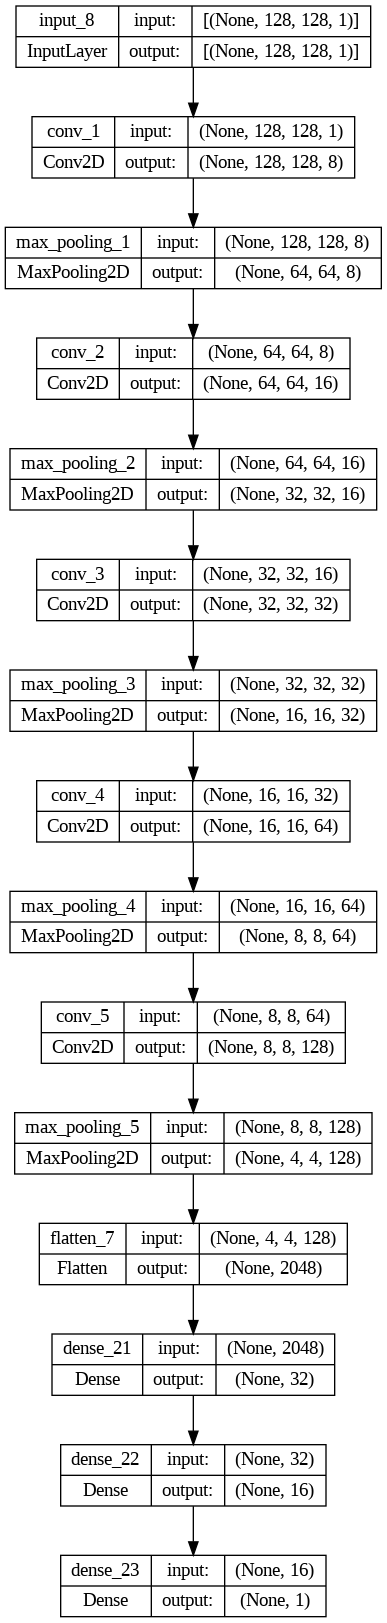

In [82]:
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses,
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name='input_8')

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.
conv_1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input)
max_poolling_1 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_1')(conv_1)
conv_2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(max_poolling_1)
max_poolling_2 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_2')(conv_2)
conv_3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(max_poolling_2)
max_poolling_3 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_3')(conv_3)
conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(max_poolling_3)
max_poolling_4 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_4')(conv_4)
conv_5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(max_poolling_4)
max_poolling_5 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_5')(conv_5)
flatten_7 = Flatten(name='flatten_7')(max_poolling_5)
dense_21 = Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = Dense(16, activation='relu', name='dense_22')(dense_21)
cnn_output = Dense(1, activation='sigmoid', name='dense_23')(dense_22)

cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.AdamW(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

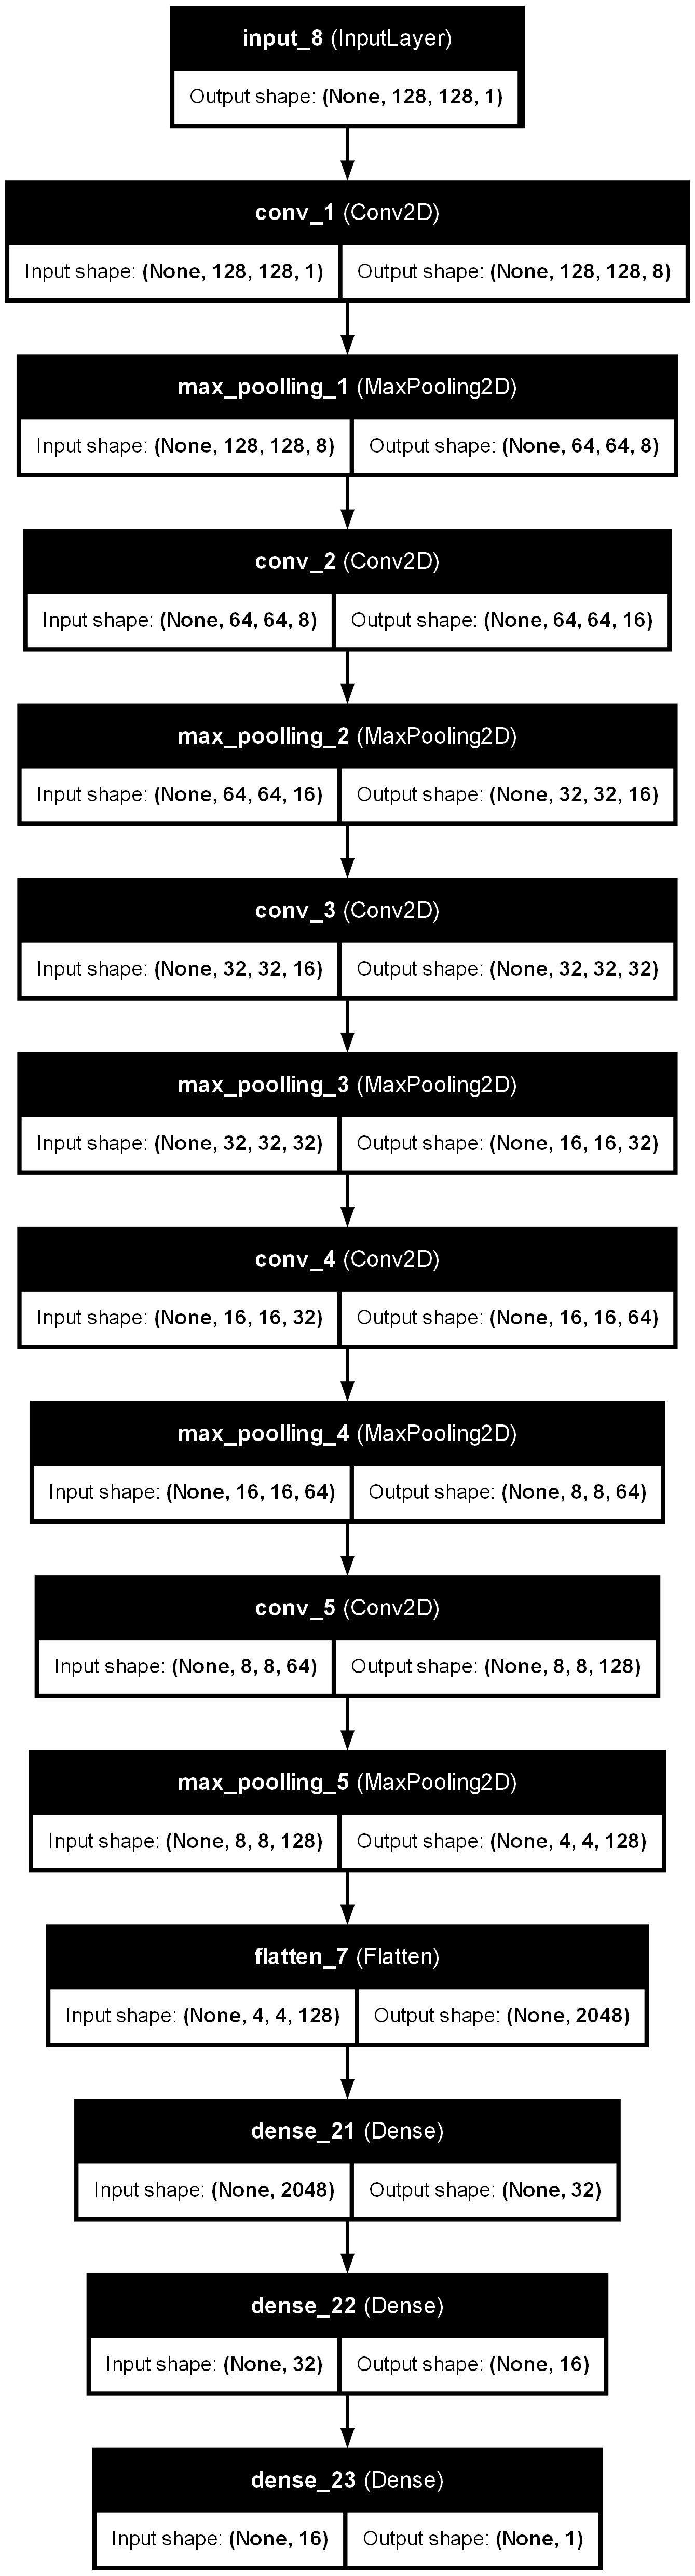

In [83]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [84]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights
)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6240 - loss: 1.5927 - val_accuracy: 0.7500 - val_loss: 0.4033
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9362 - loss: 0.1654 - val_accuracy: 0.5625 - val_loss: 0.8596
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9566 - loss: 0.1142 - val_accuracy: 0.9375 - val_loss: 0.1520
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9720 - loss: 0.0738 - val_accuracy: 0.8750 - val_loss: 0.2365
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9762 - loss: 0.0627 - val_accuracy: 0.8750 - val_loss: 0.1913
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9847 - loss: 0.0431 - val_accuracy: 0.8125 - val_loss: 0.2305
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9802 - loss: 0.0581 - val_accuracy: 0.8125 - val_loss: 0.3155
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9877 - loss: 0.0350 - val_accuracy: 1.0000 - v

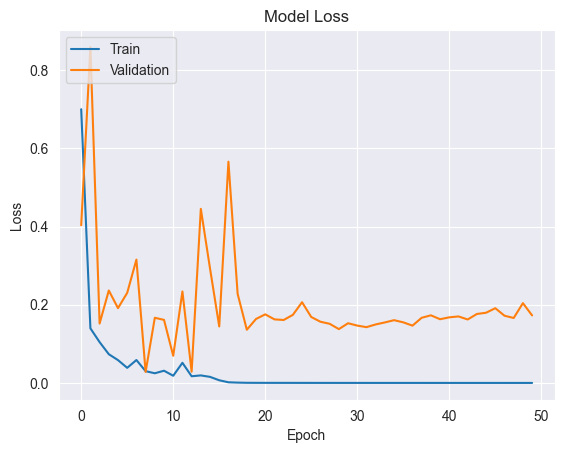

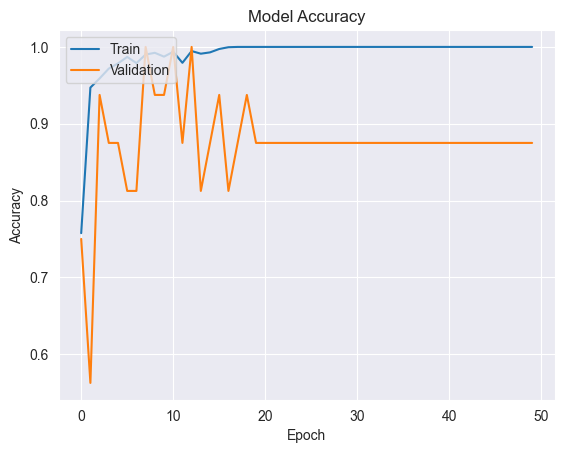

Test score (loss): 2.9786384105682373
Test accuracy: 0.7564102411270142


In [85]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

score = cnn.evaluate(test_ds, verbose=0)
print('Test score (loss):', score[0])
print('Test accuracy:', score[1])

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here

pred = cnn.predict(val_images)
for i in range(len(pred)):
    pred[i] = 0 if pred[i][0] < 0.5 else 1
confusion_matrix(val_labels, pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[6, 2],
       [0, 8]], dtype=int64)

In [99]:
# and do the same for test set
test_images = []
test_labels =[]

for img, label in test_ds:
  test_images.append(img)
  test_labels.append(label)
  
test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels).squeeze().astype(int)

pred = cnn.predict(test_images)
for i in range(len(pred)):
    pred[i] = 0 if pred[i][0] < 0.5 else 1
confusion_matrix(test_labels, pred)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[ 83, 151],
       [  1, 389]], dtype=int64)